In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
df = pd.read_csv(r"C:\Users\Mental Health Risk Prediction\data\survey.csv")

print("First 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

First 5 rows:
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often            6-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely            6-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy                        No                

## Data Preprocessing

In [4]:
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


C:\Users\A Esther Graceia\AppData\Local\Temp\ipykernel_21428\1945806138.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\A Esther Graceia\AppData\Local\Temp\ipykernel_21428\1945806138.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [5]:
df['treatment'] = df['treatment'].map({'Yes': 1, 'No': 0})

In [6]:
df.drop(['Timestamp', 'Country', 'state', 'comments'], axis=1, inplace=True)

In [7]:
df = pd.get_dummies(df, drop_first=True)

In [8]:
print("\nData types after encoding:")
print(df.dtypes)

print("\nClass distribution:")
print(df['treatment'].value_counts())


Data types after encoding:
Age                          int64
treatment                    int64
Gender_Agender                bool
Gender_All                    bool
Gender_Androgyne              bool
                             ...  
phys_health_interview_No      bool
phys_health_interview_Yes     bool
mental_vs_physical_No         bool
mental_vs_physical_Yes        bool
obs_consequence_Yes           bool
Length: 91, dtype: object

Class distribution:
treatment
1    637
0    622
Name: count, dtype: int64


In [9]:
X = df.drop('treatment', axis=1)
y = df['treatment']

In [10]:
feature_names = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Test train split

In [11]:
def evaluate(name, y_test, y_pred):
    print("Model:", name)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [13]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
evaluate("Logistic Regression", y_test, y_pred_lr)


Model: Logistic Regression
Accuracy: 0.7261904761904762
Precision: 0.7565217391304347
Recall: 0.6796875
F1 Score: 0.7160493827160493


In [14]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
evaluate("Decision Tree", y_test, y_pred_dt)


Model: Decision Tree
Accuracy: 0.6865079365079365
Precision: 0.6842105263157895
Recall: 0.7109375
F1 Score: 0.6973180076628352


In [15]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

rf = grid_rf.best_estimator_
print("\nBest RF Parameters:", grid_rf.best_params_)

y_pred_rf = rf.predict(X_test)
evaluate("Random Forest", y_test, y_pred_rf)


Best RF Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Model: Random Forest
Accuracy: 0.7261904761904762
Precision: 0.7286821705426356
Recall: 0.734375
F1 Score: 0.7315175097276264


In [16]:
svm_params = {
    'C': [0.1, 1, 5, 10],
    'gamma': [0.1, 0.01, 0.001]
}

grid_svm = GridSearchCV(SVC(), svm_params, cv=3)
grid_svm.fit(X_train, y_train)

svm = grid_svm.best_estimator_
y_pred_svm = svm.predict(X_test)
evaluate("SVM", y_test, y_pred_svm)


Model: SVM
Accuracy: 0.7222222222222222
Precision: 0.7457627118644068
Recall: 0.6875
F1 Score: 0.7154471544715447


In [17]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
evaluate("Naive Bayes", y_test, y_pred_nb)


Model: Naive Bayes
Accuracy: 0.5
Precision: 1.0
Recall: 0.015625
F1 Score: 0.03076923076923077


In [18]:
xgb = XGBClassifier(
    n_estimators=100,      
    max_depth=3,           
    learning_rate=0.05,   
    subsample=0.7,           
    colsample_bytree=0.7, 
    reg_alpha=1,         
    reg_lambda=2,            
    min_child_weight=3,    
    gamma=0.2,               
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
evaluate("XGBoost", y_test, y_pred_xgb)

Model: XGBoost
Accuracy: 0.7261904761904762
Precision: 0.7565217391304347
Recall: 0.6796875
F1 Score: 0.7160493827160493


C:\Users\A Esther Graceia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:46:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [19]:
voting = VotingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('svm', svm)],
    voting='hard'
)

voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)
evaluate("Voting Classifier", y_test, y_pred_voting)

C:\Users\A Esther Graceia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:46:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model: Voting Classifier
Accuracy: 0.7182539682539683
Precision: 0.7394957983193278
Recall: 0.6875
F1 Score: 0.7125506072874493


In [20]:
print("\nOverfitting Check (Random Forest)")
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))



Overfitting Check (Random Forest)
Train Accuracy: 0.788480635551142
Test Accuracy: 0.7261904761904762


In [21]:
print("\nOverfitting Check (XGBoost)")
print("Train Accuracy:", xgb.score(X_train, y_train))
print("Test Accuracy:", xgb.score(X_test, y_test))


Overfitting Check (XGBoost)
Train Accuracy: 0.7864945382323734
Test Accuracy: 0.7261904761904762



Confusion Matrix:
 [[89 35]
 [34 94]]


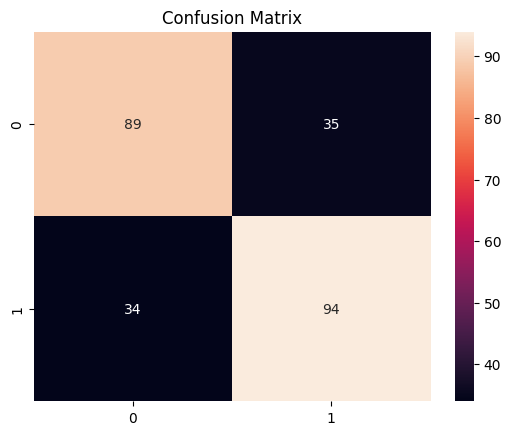

In [22]:
cm = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


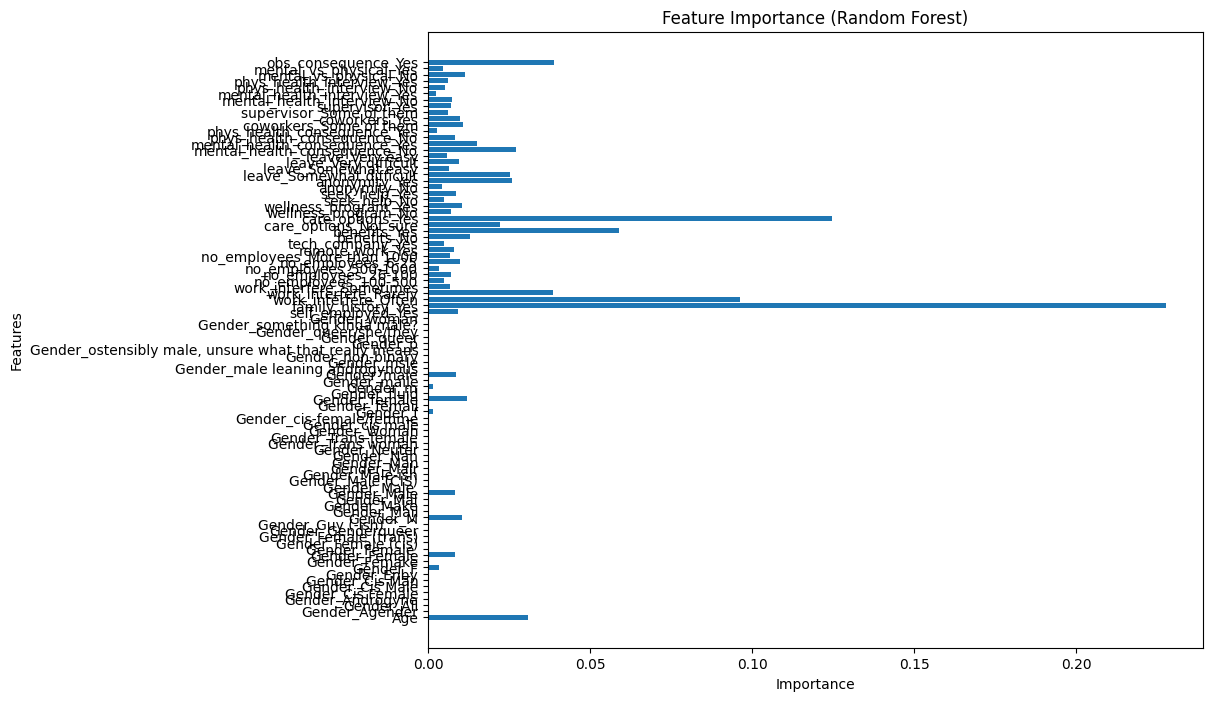

In [23]:
importances = rf.feature_importances_

plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.show()